<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing libraries

In [ ]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
!pip install jdatetime
!pip install scikit-optimize
!pip install bayesian-optimization

# data manipulation

inculding: 1-becoming one with data, 2-feature engieering, and 3-preprocessing

In [44]:
import pandas as pd # to import the excel file
import numpy as np  # to deal with numbers
import jdatetime    # to convert Jalali datatime to Gregorian
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import lightgbm as lgb

In [46]:
## importing data files
data_df = pd.read_excel("consumption.xlsx")
temp_df = pd.read_csv("temperature.csv")

In [47]:
# Apply the conversion directly using a lambda function
data_df['time'] = data_df['date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
data_df.drop(columns="date",axis = 1, inplace=True)

In [56]:
# making the dataframe into a column vector of time and values
# we make to lists of hours and their repective values and then concatenate them
time_hourly = []
values_hourly = []
list_of_hours = np.arange(1,25)
for i in range(len(data_df["time"])):
    time = pd.to_datetime(data_df['time'][i], format='%Y-%m-%d') + pd.to_timedelta(list_of_hours, unit='h').values
    values = data_df.loc[i][1:].values
    time_hourly.append(time)
    values_hourly.append(values)

In [6]:
time_concatenated = np.concatenate(time_hourly)
values_concatenated = np.concatenate(values_hourly)

In [57]:
# and now we make the new df
new_df = pd.DataFrame({"time": time_concatenated, "power": values_concatenated})
temp_df["time"] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d')
print(f" changed the data frame from {data_df.shape} to {new_df.shape} ")

 changed the data frame from (730, 25) to (17520, 2) 


In [58]:
# Concatenate based on the 'Time' column
concat_df = pd.concat([new_df.set_index('time'), temp_df.set_index('time')], axis=1, join='inner')
# Reset the index to make 'Time' a column again
concat_df.reset_index(inplace=True)
concat_df.head(2)

,time,power,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


### adding features to the dataset


In [59]:
# addding mutiple columns using the "time" col
concat_df["week_day"] = concat_df["time"].dt.weekday
concat_df["day"] = concat_df["time"].dt.day
concat_df['month'] = concat_df["time"].dt.month
concat_df["hour"] = concat_df["time"].dt.hour

# extracting features
concat_df['up_of_month']=(concat_df['day']<=10).astype(int)
concat_df['down_of_month']=(concat_df['day']>20).astype(int)
concat_df['sin_day']=np.sin(2*np.pi*concat_df['day']/30)
concat_df['cos_day']=np.cos(2*np.pi*concat_df['day']/30)

concat_df['morning']=((concat_df['hour']>5)&(concat_df['hour']<=12)).astype(int)
concat_df['afternoon']=((concat_df['hour']>12)&(concat_df['hour']<=19)).astype(int)
concat_df['evening']=(1-concat_df['morning']-concat_df['afternoon']).astype(int)

#  whether its thursday | friday or not
concat_df['weekend'] = ((concat_df["week_day"] == 4) | (concat_df["week_day"] == 3)).astype(int)
concat_df['time_slot'] = pd.cut(concat_df["hour"], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4], right=False)
concat_df['peak_load'] = ((concat_df["hour"] >= 11) & (concat_df["hour"] <= 15)).astype(int)

concat_df['spring']=((concat_df['month']>=3)&(concat_df['month']<=5)).astype(int)
concat_df['summer']=((concat_df['month']>=6)&(concat_df['month']<=8)).astype(int)
concat_df['fall']=((concat_df['month']>=9)&(concat_df['month']<=11)).astype(int)
concat_df['winter']=((concat_df['month']==12)&(concat_df['month']<=2)).astype(int)

# adding the mean of the past 4 "values" for each row
previous_four_mean = np.array(concat_df["power"][0:4].values).astype(np.float32)
for i in range(4,len(concat_df)):
  previous_four_mean = np.append(previous_four_mean, concat_df["power"][i-4:i].values.mean()).astype(np.float32)
concat_df["four_mean"] = previous_four_mean

# dropping non-informative columns
concat_df.drop( ["day", "week_day", "month","hour"] , axis = 1, inplace = True)
# concat_df.drop("time", axis=1 , inplace = True)

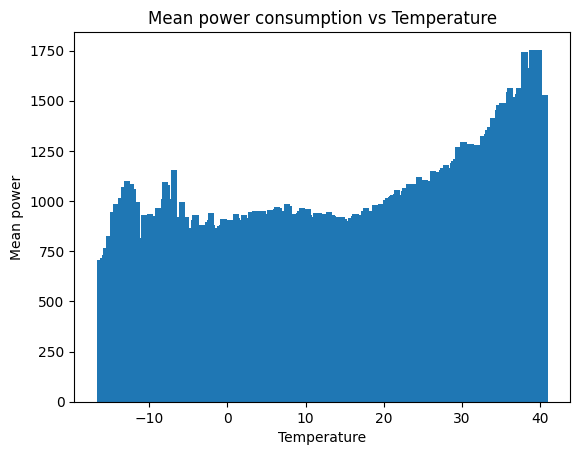

In [61]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt

unique_temps = np.unique(concat_df['temp'])
# Plotting
plt.bar(unique_temps, concat_df.groupby('temp')['power'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean power')
plt.title('Mean power consumption vs Temperature')
plt.show()

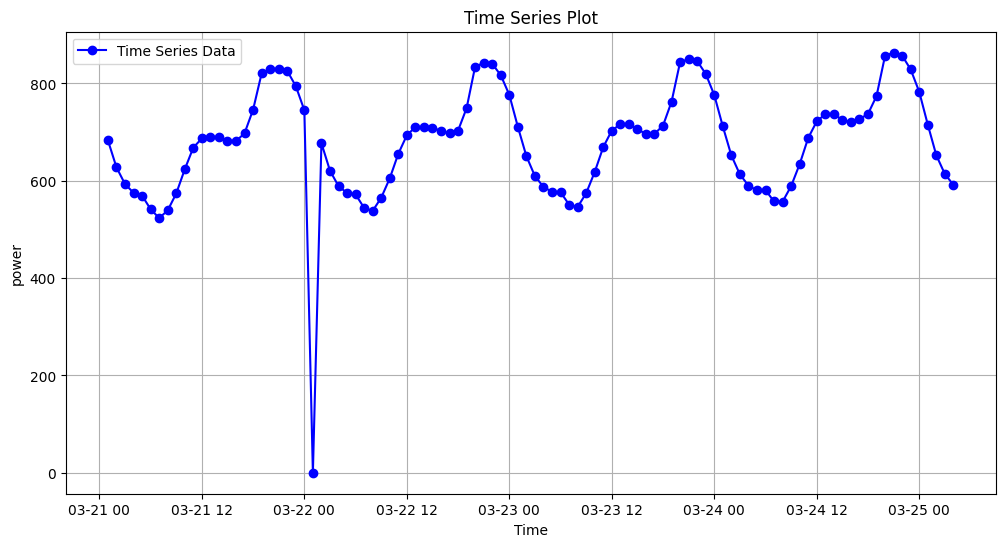

In [62]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(concat_df['time'][:100], concat_df['power'][:100], label='Time Series Data', marker='o', linestyle='-', color='b')

plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# normalizing the value and mean columns
# Normalizing using the Standard Deviation Normalization method
concat_df_value_mean = concat_df["power"].mean()
concat_df_value_std = concat_df["power"].std()
concat_df.loc[:, "power"] = (concat_df["power"] - concat_df_value_mean) / concat_df_value_std

concat_df_four_mean_mean = concat_df["four_mean"].mean()
concat_df_four_mean_std = concat_df["four_mean"].std()
concat_df.loc[:, "four_mean"] = (concat_df["four_mean"] - concat_df_four_mean_mean) / concat_df_four_mean_std

# changed the "values" columns dtype to float
concat_df["power"] = pd.to_numeric(concat_df['power'], errors='coerce').astype(float)

In [64]:
# adding 3 more features, which are the values of three previous hours
concat_df['one_hour_ago'] = concat_df['power'].shift(1)
concat_df['two_hours_ago'] = concat_df['power'].shift(2)
concat_df['three_hours_ago'] = concat_df['power'].shift(3)

columns_to_fill = ['one_hour_ago', 'two_hours_ago', 'three_hours_ago']
concat_df[columns_to_fill] = concat_df[columns_to_fill].fillna(method='bfill')

# Lightgbm Model


## hyper parametere tuning

In [65]:
# Drop any other columns that are not features or the target variable
features = concat_df.drop(columns=['power','time'],axis =1)
target = concat_df['power']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

# Define the objective function for Bayesian Optimization
def lgbm_cv(num_leaves, learning_rate, n_estimators, feature_fraction, bagging_fraction, bagging_freq, min_child_samples):
    params = {
        'objective': 'regression',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'bagging_fraction': max(min(bagging_fraction, 1), 0),
        'bagging_freq': int(bagging_freq),
        'min_child_samples': int(min_child_samples),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt'
    }

    # Perform K-Fold cross-validation on the training set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_kf, y_train_kf)

        # Predict on the validation set and calculate RMSE
        y_pred = model.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
        rmse_scores.append(rmse)

    # Return the average RMSE across folds
    return -np.mean(rmse_scores)

# Define the parameter space for Bayesian Optimization
pbounds = {
    'num_leaves': (5, 50),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 200),
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.1, 0.9),
    'bagging_freq': (1, 10),
    'min_child_samples': (5, 30)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.1491   | 0.3996    | 9.556     | 0.6856    | 0.1836    | 8.9       | 73.4      | 7.614     |
| 2         | -0.1854   | 0.7929    | 6.41      | 0.6665    | 0.01597   | 29.25     | 174.9     | 14.56     |
| 3         | -0.1552   | 0.2455    | 2.651     | 0.3434    | 0.1622    | 15.8      | 93.68     | 32.53     |
| 4         | -0.1433   | 0.2116    | 3.629     | 0.3931    | 0.1423    | 24.63     | 79.95     | 28.14     |
| 5         | -0.1179   | 0.5739    | 1.418     | 0.586     | 0.05945   | 6.626     | 192.3     | 48.45     |
| 6         | -0.1765   | 0.7467    | 3.742     | 0.1781    | 0.2084    | 16.0      | 68.31     | 27.28     |
| 7         | -0.1675   | 0.1275    | 9.184     | 0.307     | 0.2021    | 12.79     | 128.0     | 29.6      |
| 8       

In [66]:
best_params

{'bagging_fraction': 0.40312747751207423,
 'bagging_freq': 2,
 'feature_fraction': 0.8861754497516044,
 'learning_rate': 0.1260292569340899,
 'min_child_samples': 6,
 'n_estimators': 191,
 'num_leaves': 48}

## training phase
train the model using the "best_params"

In [67]:
# Train the final model with the best hyperparameters using the entire training set
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final model RMSE on the test set: {rmse_test}")

[LightGBM] [Warning] feature_fraction is set=0.8861754497516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861754497516044
[LightGBM] [Warning] bagging_fraction is set=0.40312747751207423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40312747751207423
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8861754497516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861754497516044
[LightGBM] [Warning] bagging_fraction is set=0.40312747751207423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40312747751207423
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

## plotting the results
plotting the actual values and preicted ones for both training and testing data

In [69]:
actual_train_values = concat_df.loc[X_train.index, ['time','power']].sort_index()
actual_train_values['predicted_power'] = final_model.predict(X_train.sort_index())
print(actual_train_values.head())
rmse_train = np.sqrt(mean_squared_error(actual_train_values['power'], actual_train_values['predicted_power']))
print(f"Final model RMSE on the train set: {rmse_train}")

[LightGBM] [Warning] feature_fraction is set=0.8861754497516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861754497516044
[LightGBM] [Warning] bagging_fraction is set=0.40312747751207423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40312747751207423
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
                 time     power  predicted_power
0 2021-03-21 01:00:00 -1.450911        -1.425400
1 2021-03-21 02:00:00 -1.712721        -1.534174
2 2021-03-21 03:00:00 -1.874550        -1.706555
4 2021-03-21 05:00:00 -1.986965        -1.870980
5 2021-03-21 06:00:00 -2.118310        -1.996468
Final model RMSE on the train set: 0.065929466080156


In [70]:
actual_test_values = concat_df.loc[X_test.index, ['time','power']].sort_index()
actual_test_values['predicted_power'] = final_model.predict(X_test.sort_index())
print(actual_train_values.head())
rmse_test = np.sqrt(mean_squared_error(actual_test_values['power'], actual_test_values['predicted_power']))
print(f"Final model RMSE on the test set: {rmse_test}")

[LightGBM] [Warning] feature_fraction is set=0.8861754497516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861754497516044
[LightGBM] [Warning] bagging_fraction is set=0.40312747751207423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40312747751207423
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
                 time     power  predicted_power
0 2021-03-21 01:00:00 -1.450911        -1.425400
1 2021-03-21 02:00:00 -1.712721        -1.534174
2 2021-03-21 03:00:00 -1.874550        -1.706555
4 2021-03-21 05:00:00 -1.986965        -1.870980
5 2021-03-21 06:00:00 -2.118310        -1.996468
Final model RMSE on the test set: 0.0886802089710797


### denormalization stage

In [71]:
actual_train_values['power'] = (actual_train_values['power']*concat_df_value_std) +concat_df_value_mean
actual_train_values['predicted_power'] = (actual_train_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

actual_test_values['power'] = (actual_test_values['power']*concat_df_value_std) +concat_df_value_mean
actual_test_values['predicted_power'] = (actual_test_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

### plots

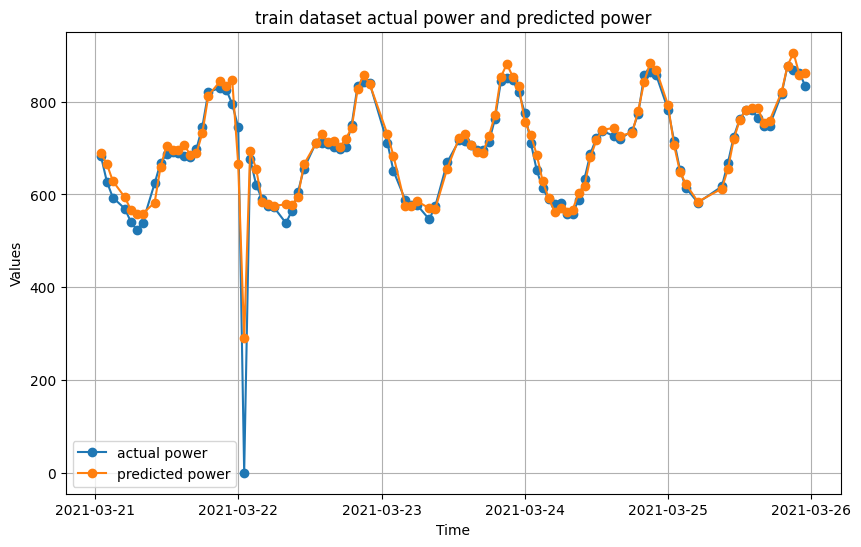

In [72]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('train dataset actual power and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

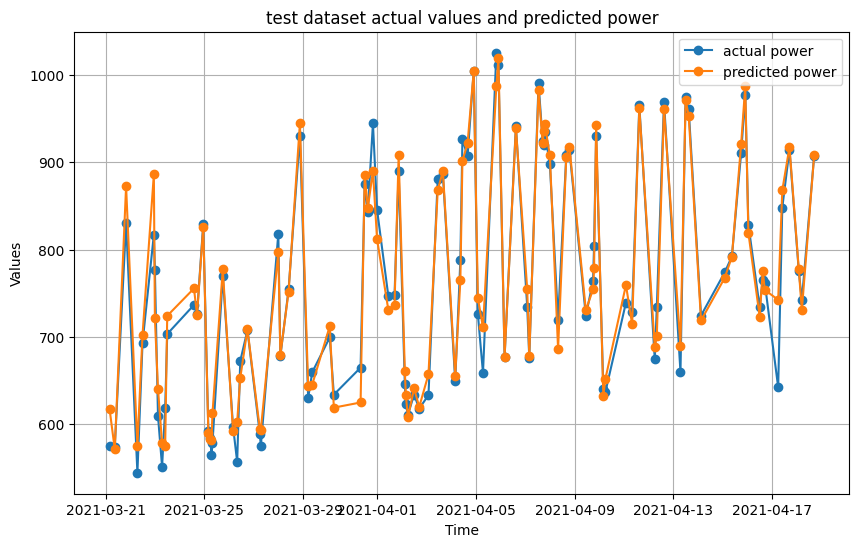

In [73]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network model
developing a simple MLP for regression task using Pytorch framework

In [74]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## train-test split

In [75]:
# convert the data to a PyTorch tensor
X = torch.tensor(concat_df.drop(columns=['power','time'],axis =1).values, dtype=torch.float32)
y = torch.tensor(concat_df["power"].values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

## constructing the model

In [76]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, num_hidden_units:int, num_layers:int):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(num_hidden_units, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## building train and evaluation loop function

In [77]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):

        ### Training
        train_loss = 0
        for inputs, labels in train_loader:

            model.train()

            outputs = model(inputs.to(device))

            loss = criterion(outputs, labels.view(-1, 1).to(device))
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_loader)

        # Evaluate the model on the test set
        model.eval()
        with torch.inference_mode():
            test_inputs, test_labels = test_data
            predictions = model(test_inputs.to(device))
            test_loss = criterion(predictions, test_labels.to(device).view(-1, 1))

        ## Print out what's happening
        if (epoch+1) % 10 == 0:
            print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Epoch: {epoch+1}")


   #return train_loss , test_loss

## Grid-search hyper-parameter tuning

In [78]:
# Grid search hyperparameter tuning
param_grid = {
    'num_hidden_units': [8,16, 32],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [79]:
best_model = None
best_params = None
best_loss = float('inf')

In [80]:
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
test_data = (X_test.to(device), y_test.to(device))
counter = 1
for params in ParameterGrid(param_grid):

    print(f"{counter} set of params in total {len(ParameterGrid(param_grid))}")
    learning_rate = params['learning_rate']
    del params['learning_rate']  # Remove learning_rate from params

    model = NeuralNetwork(input_size=X.shape[1], **params).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_and_evaluate(model, train_loader, test_data, criterion, optimizer, num_epochs = 5)

    # Evaluate the model on the test set and update the best model if needed
    model.eval()
    with torch.inference_mode():
        predictions = model(X_test.to(device))
        test_loss = mean_squared_error(predictions.numpy(), y_test.numpy())
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model
            best_params = params
            best_learning_rate = learning_rate
    counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

1 set of params in total 27
Train loss: 0.02463 | Test loss: 0.01725, Epoch: 10
2 set of params in total 27
Train loss: 0.02132 | Test loss: 0.01377, Epoch: 10
3 set of params in total 27
Train loss: 0.02056 | Test loss: 0.01532, Epoch: 10
4 set of params in total 27
Train loss: 0.02161 | Test loss: 0.01356, Epoch: 10
5 set of params in total 27
Train loss: 0.01778 | Test loss: 0.01306, Epoch: 10
6 set of params in total 27
Train loss: 0.01676 | Test loss: 0.01348, Epoch: 10
7 set of params in total 27
Train loss: 0.02017 | Test loss: 0.01526, Epoch: 10
8 set of params in total 27
Train loss: 0.01744 | Test loss: 0.01019, Epoch: 10
9 set of params in total 27
Train loss: 0.01683 | Test loss: 0.01201, Epoch: 10
10 set of params in total 27
Train loss: 0.02527 | Test loss: 0.01511, Epoch: 10
11 set of params in total 27
Train loss: 0.02047 | Test loss: 0.01571, Epoch: 10
12 set of params in total 27
Train loss: 0.02361 | Test loss: 0.02106, Epoch: 10
13 set of params in total 27
Train lo

In [36]:
best_learning_rate

0.001

## training model using the grid search hyper-parameter method

In [1]:
# Train the best model on the entire dataset
best_model = NeuralNetwork(input_size=X.shape[1], **best_params)
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
train_and_evaluate(best_model.to(device),
                   DataLoader(TensorDataset(X.to(device), y.to(device)), batch_size=32, shuffle=True),
                   (X_test.to(device), y_test.to(device)),
                   nn.MSELoss(),
                   optimizer, num_epochs=50)

NameError: ignored

In [38]:
denormalized_values = (concat_df["power"] * concat_df_value_std) +concat_df_value_mean
dernomalized_predictions = (best_model(X.to(device)).detach().numpy() * concat_df_value_std) +concat_df_value_mean

In [39]:
plot_df = pd.DataFrame({"time": concat_df["time"],
                        "actual_values": denormalized_values,
                        "predictions": dernomalized_predictions.flatten()})

In [40]:
train_plot_df = plot_df[:int(len(plot_df)*0.9)]
test_plot_df = plot_df[int(len(plot_df)*0.9):]

In [41]:
rmse_test = np.sqrt(mean_squared_error(concat_df["power"][int(len(concat_df)*0.9):], best_model(X.to(device)).detach().numpy()[int(len(concat_df)*0.9):].flatten()))
print(f"Final model RMSE on the test set: {rmse_test}")

Final model RMSE on the test set: 0.0563737730839501


## plotting the train and test dataset values vs their predictions

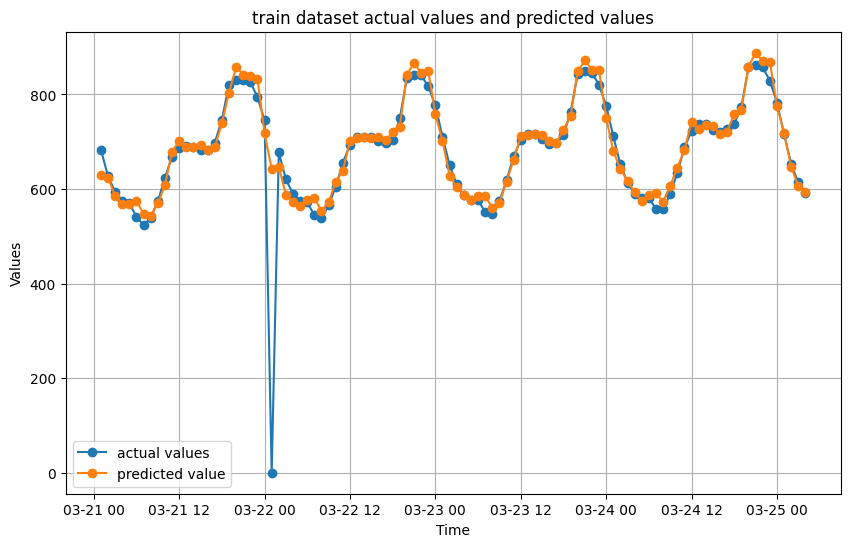

In [42]:
# Plotting train dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('train dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

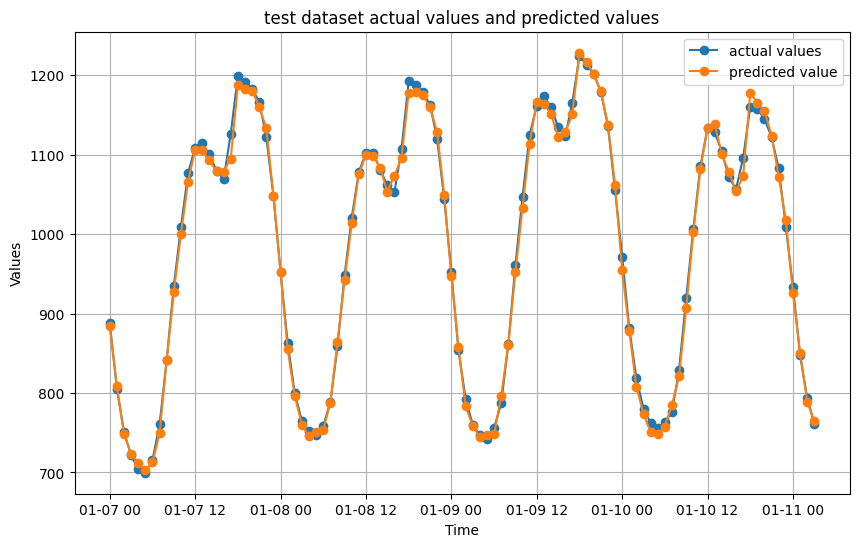

In [43]:
# Plotting test dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()